In [3]:
!pip install catboost

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, precision_recall_curve
import matplotlib.pyplot as plt

In [5]:
# Load the dataset
df = pd.read_csv('credit_risk_dataset.csv')

In [6]:
df.columns

Index(['person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_default_on_file', 'cb_person_cred_hist_length'],
      dtype='object')

In [7]:
# 1. Clean and Preprocess the Dataset
# Define features and target
features = [
    'person_age', 'person_income', 'person_home_ownership', 'person_emp_length',
    'loan_intent', 'loan_grade', 'loan_amnt', 'loan_int_rate', 'loan_percent_income',
    'cb_person_default_on_file', 'cb_person_cred_hist_length'
]
target = 'loan_status'  # 1 = default, 0 = no default

X = df[features]
y = df[target]

In [8]:
# Define numeric and categorical features
numeric_features = ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 
                    'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length']
categorical_features = ['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file']

In [9]:
# Preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [10]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [11]:
# 2. Train Binary Classification Models

# Model 1: Logistic Regression
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

lr_pipeline.fit(X_train, y_train)
lr_probs = lr_pipeline.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print(f'Logistic Regression AUC: {lr_auc:.4f}')

Logistic Regression AUC: 0.8693


In [16]:
# Model 2: XGBoost
xgb_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

xgb_pipeline.fit(X_train, y_train)
xgb_probs = xgb_pipeline.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
print(f'XGBoost AUC: {xgb_auc:.4f}')

C:\Users\bless\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost AUC: 0.9518


In [13]:
# 3. Define Business Cost Values
# Assume:
# - False Negative (FN): Predicting no default but actual default -> Cost of loan loss (e.g., 5 units)
# - False Positive (FP): Predicting default but no default -> Cost of lost opportunity (e.g., 1 unit)
cost_fn = 5
cost_fp = 1

In [17]:
# 4. Adjust Model Threshold to Minimize Total Business Cost (using XGBoost)
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)
total_costs = []
for thresh in thresholds:
    y_pred = (xgb_probs >= thresh).astype(int)
    fp = np.sum((y_pred == 1) & (y_test == 0))
    fn = np.sum((y_pred == 0) & (y_test == 1))
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    total_costs.append(total_cost)

In [18]:
# Find the threshold with minimum cost
min_cost_idx = np.argmin(total_costs)
optimal_threshold = thresholds[min_cost_idx]
min_cost = total_costs[min_cost_idx]

print(f'Optimal Threshold (XGBoost): {optimal_threshold:.4f}')
print(f'Minimum Total Business Cost: {min_cost}')

Optimal Threshold (XGBoost): 0.1691
Minimum Total Business Cost: 1495


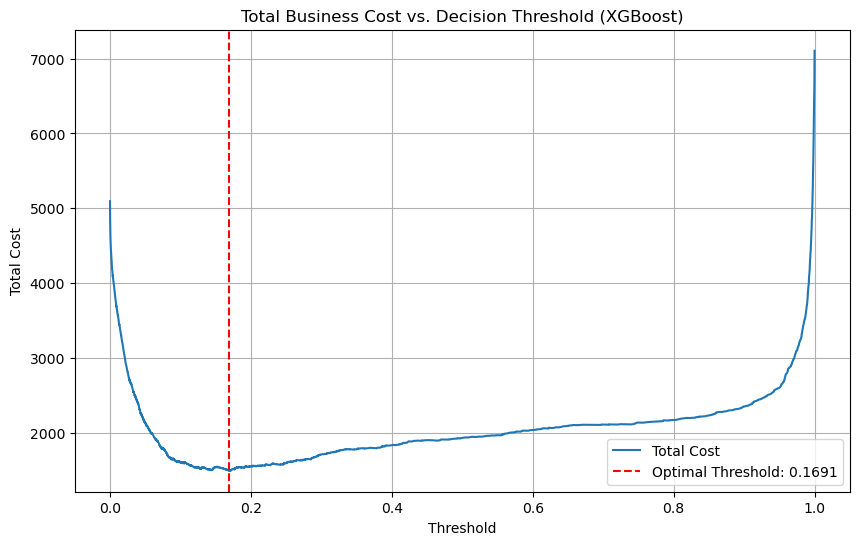

In [19]:
# Plot total cost vs. threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, total_costs, label='Total Cost')
plt.axvline(optimal_threshold, color='red', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.4f}')
plt.title('Total Business Cost vs. Decision Threshold (XGBoost)')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
# Evaluate at optimal threshold
y_pred_optimal = (xgb_probs >= optimal_threshold).astype(int)
fp = np.sum((y_pred_optimal == 1) & (y_test == 0))
fn = np.sum((y_pred_optimal == 0) & (y_test == 1))
print(f'Performance at Optimal Threshold (XGBoost):')
print(f'AUC: {xgb_auc:.4f}')
print(f'False Positives: {fp}, False Negatives: {fn}')

Performance at Optimal Threshold (XGBoost):
AUC: 0.9518
False Positives: 475, False Negatives: 204
